In [9]:
import pandas as pd
from itertools import combinations
from collections import Counter
from scipy.stats import hypergeom
import networkx as nx
import matplotlib.pyplot as plt


In [10]:
# Carichiamo il dataset 
file_path =  r'C:\Users\totim\Downloads\dataset_elezioni_CS_anonymized.xlsx'
dataset = pd.read_excel(file_path, header=None)

# Puliamo il dataset
dataset_cleaned = dataset.replace('[NA]', pd.NA)  # Sostituiamo '[NA]' con valori NA effettivi

dataset_cleaned = dataset_cleaned.dropna(how='all', axis=0)  # Rimuoviamo righe interamente vuote

# Creiamo una lista di voti validi per ogni elettore
votes_cleaned = dataset_cleaned.apply(lambda row: [x for x in row if pd.notna(x)], axis=1)

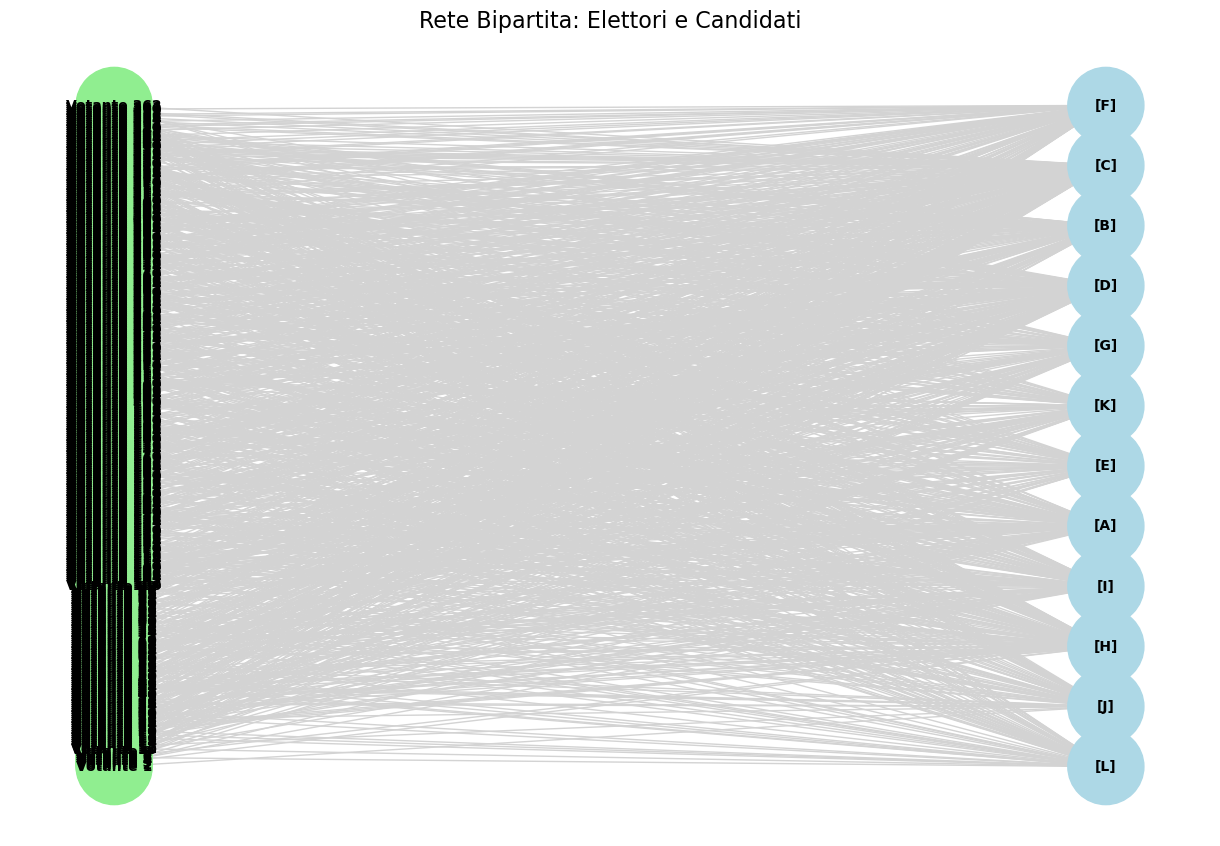

In [11]:
# Creazione della rete bipartita
G = nx.Graph()

# Aggiungiamo i nodi degli elettori (indici della tabella)
voters = [f"Votante {i+1}" for i in range(len(votes_cleaned))]
G.add_nodes_from(voters, bipartite=0)

# Aggiungiamo i nodi dei candidati (lettere nella tabella)
voted_candidates = set(v for votes in votes_cleaned for v in votes)
G.add_nodes_from(voted_candidates, bipartite=1)

# Aggiungiamo gli archi tra elettori e candidati
for idx, votes in enumerate(votes_cleaned):
    voter = f"Votante {idx+1}"
    for candidate in votes:
        G.add_edge(voter, candidate)

# Disegno della rete bipartita
plt.figure(figsize=(12, 8))

# Posizionamento dei nodi per una rete bipartita
pos = nx.drawing.layout.bipartite_layout(G, nodes=voters)

# Disegniamo i nodi e gli archi
nx.draw(
    G, pos, with_labels=True,
    node_color=['lightgreen' if node in voters else 'lightblue' for node in G.nodes],
    edge_color='lightgray',
    node_size=3000, font_size=10, font_weight='bold'
)

# Titolo del grafico
plt.title("Rete Bipartita: Elettori e Candidati", fontsize=16)
plt.show()

In [12]:
# Dizionari per registrare co-occorrenze e voti totali
cooccurrence_dict = Counter()
vote_counts = Counter()

# Iteriamo su ogni elettore e calcoliamo le co-occorrenze
for votes in votes_cleaned:
    for candidato in votes:
        vote_counts[candidato] += 1  # Conteggio dei voti totali per ogni candidato
    for pair in combinations(sorted(votes), 2):  # Calcoliamo le coppie di voti
        cooccurrence_dict[pair] += 1  # Incrementiamo le co-occorrenze

# Numero totale di elettori
N = len(votes_cleaned)

# Parametri per la Bonferroni correction
alpha = 0.05  # Livello di significatività
T = len(cooccurrence_dict)  # Numero totale di test (coppie di candidati)
bonferroni_threshold = alpha / T  # Soglia di Bonferroni

# Lista per FDR correction
fdr_links = []
results = []

# Calcoliamo i p-value direttamente per ciascuna coppia
for idx, ((candidato1, candidato2), count) in enumerate(cooccurrence_dict.items(), 1):
    NA = vote_counts[candidato1]  # Numero di voti totali per il primo candidato
    NB = vote_counts[candidato2]  # Numero di voti totali per il secondo candidato
    # Calcoliamo il p-value usando la distribuzione ipergeometrica
    p_value = hypergeom.sf(count - 1, N, NA, NB)
    # Applichiamo la Bonferroni correction
    if p_value < bonferroni_threshold:
        results.append((candidato1, candidato2, count, p_value))
    # Applichiamo la FDR correction
    fdr_threshold = alpha * idx / T
    if p_value < fdr_threshold:
        fdr_links.append((candidato1, candidato2, count, p_value))

# Legami significativi con Bonferroni correction
network_links_bonferroni = [f"{candidato1}{candidato2}" for candidato1, candidato2, _, _ in results]
# Legami significativi con FDR correction
network_links_fdr = [f"{candidato1}{candidato2}" for candidato1, candidato2, _, _ in fdr_links]

print("Coppie significative (Bonferroni):")
for candidato1, candidato2, count, p_value in results:
    print(f"{candidato1} e {candidato2} sono stati votati insieme {count} volte, p-value: {p_value}")

print("\nCoppie significative (FDR):")
for candidato1, candidato2, count, p_value in fdr_links:
    print(f"{candidato1} e {candidato2} sono stati votati insieme {count} volte, p-value: {p_value}")

Coppie significative (Bonferroni):
[B] e [J] sono stati votati insieme 35 volte, p-value: 2.591183937310328e-07
[G] e [J] sono stati votati insieme 27 volte, p-value: 8.49811674988022e-05
[A] e [D] sono stati votati insieme 66 volte, p-value: 4.969270885797649e-12
[C] e [D] sono stati votati insieme 83 volte, p-value: 8.761113995809688e-07
[D] e [I] sono stati votati insieme 61 volte, p-value: 3.940505198589747e-08
[H] e [L] sono stati votati insieme 35 volte, p-value: 6.519486408798661e-08
[C] e [I] sono stati votati insieme 60 volte, p-value: 0.00011479207502298763
[A] e [I] sono stati votati insieme 44 volte, p-value: 1.1139800812350158e-05

Coppie significative (FDR):
[B] e [J] sono stati votati insieme 35 volte, p-value: 2.591183937310328e-07
[G] e [J] sono stati votati insieme 27 volte, p-value: 8.49811674988022e-05
[A] e [D] sono stati votati insieme 66 volte, p-value: 4.969270885797649e-12
[C] e [D] sono stati votati insieme 83 volte, p-value: 8.761113995809688e-07
[D] e [I] so

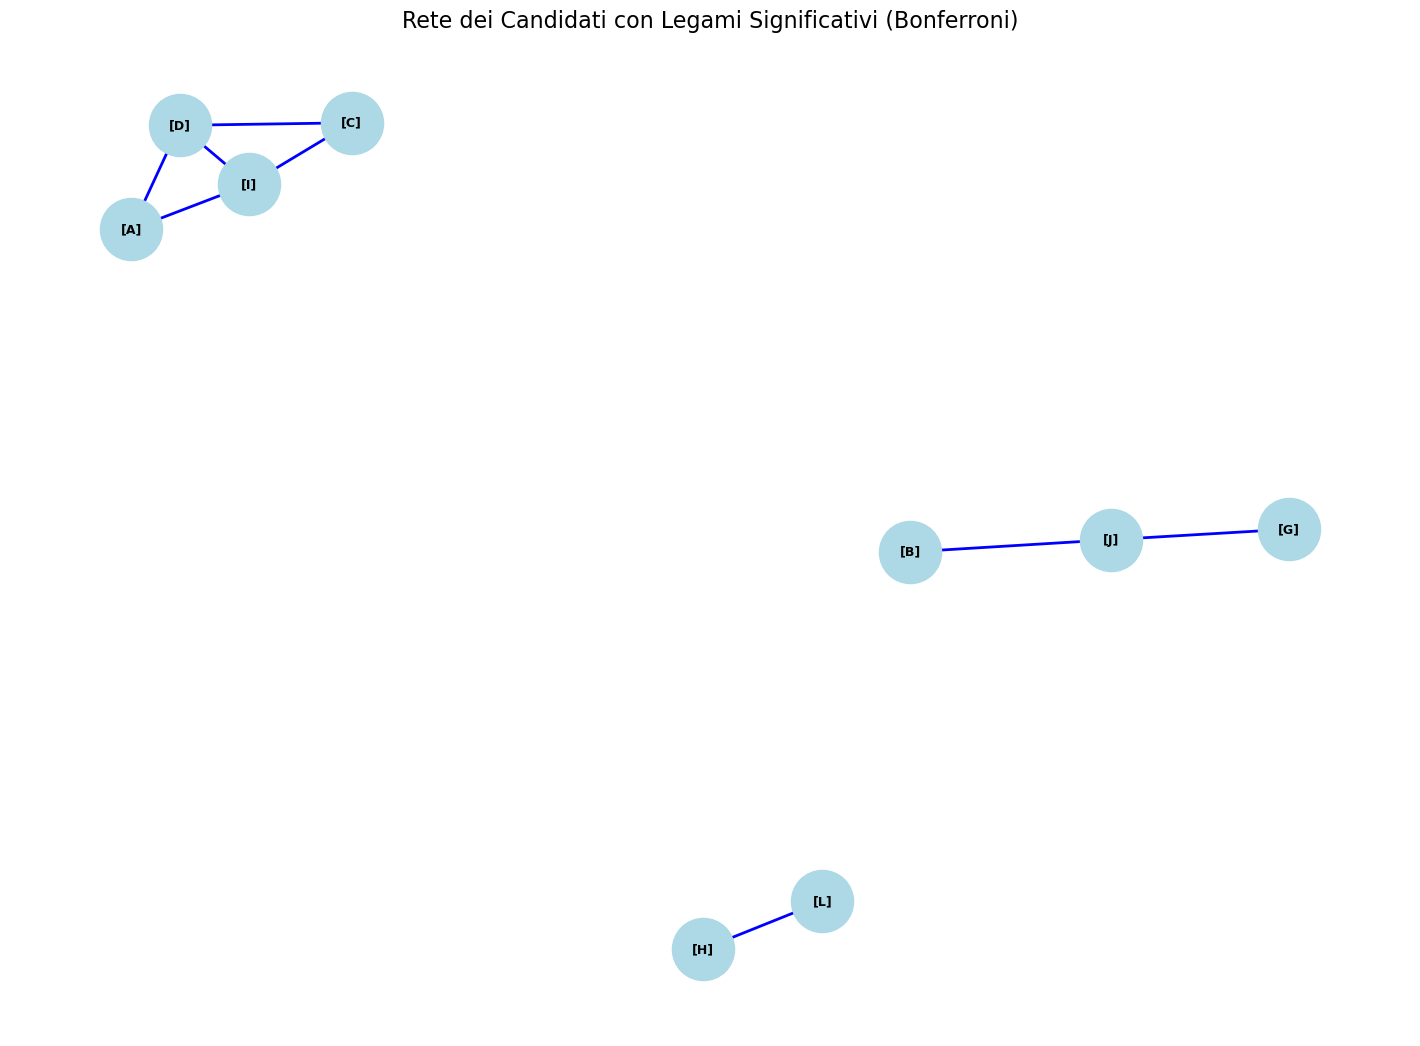

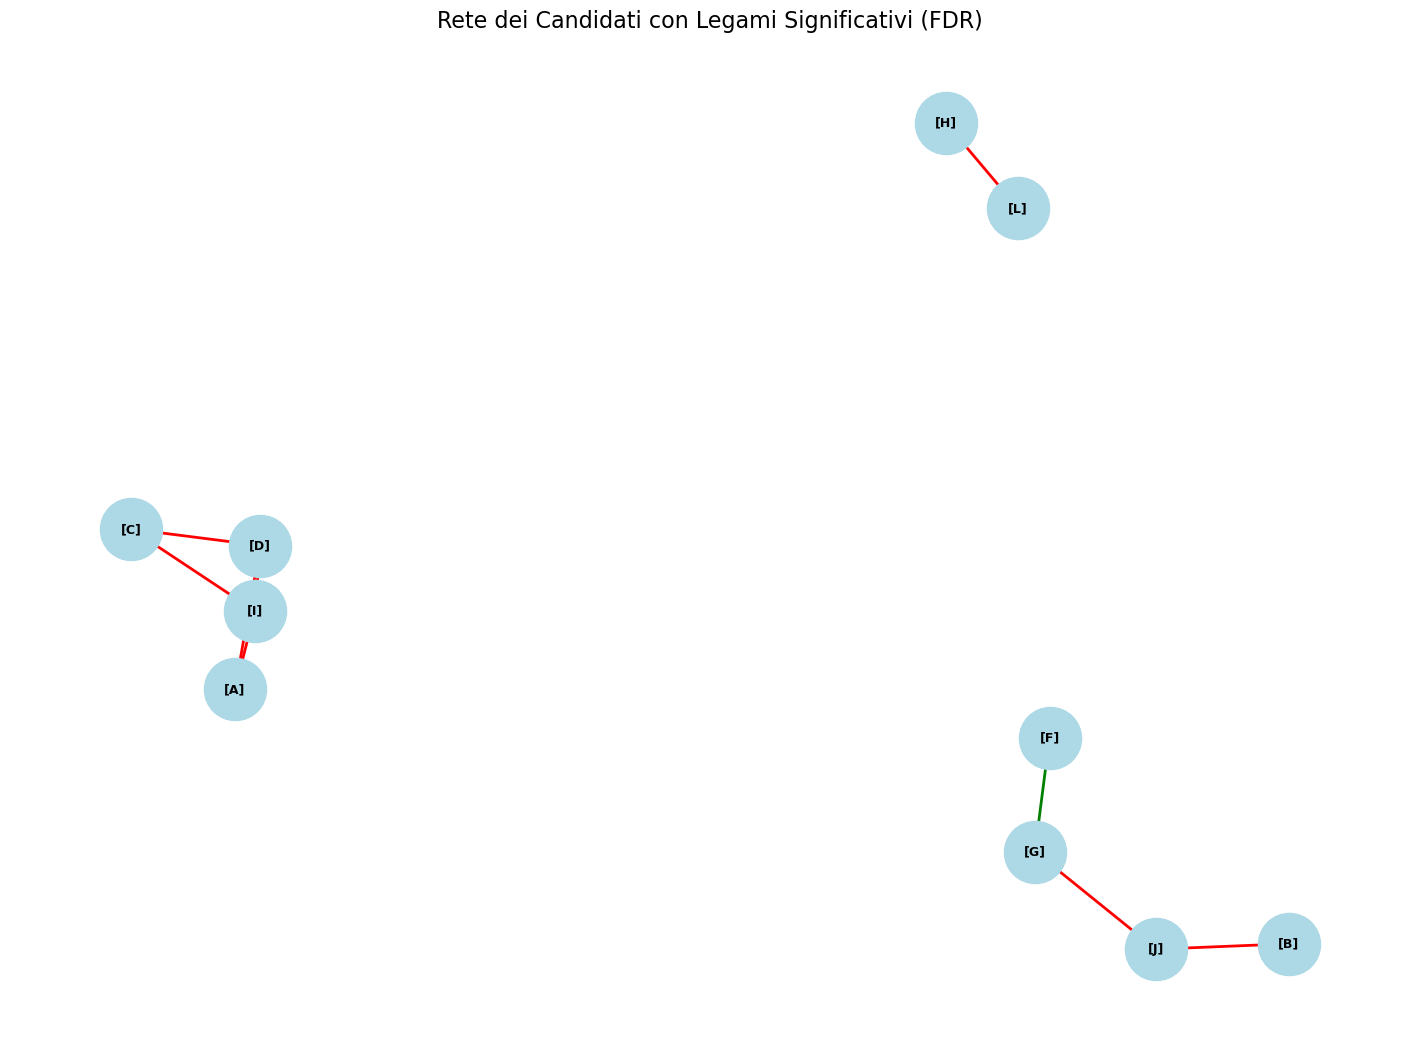

In [13]:
# Creazione della rete dei candidati con legami significativi (Bonferroni)
significant_G_bonferroni = nx.Graph()
for candidato1, candidato2, _, _ in results:
    significant_G_bonferroni.add_edge(candidato1, candidato2)

plt.figure(figsize=(14, 10))
pos_bonferroni = nx.spring_layout(significant_G_bonferroni, k=0.5)
nx.draw(
    significant_G_bonferroni, pos_bonferroni, with_labels=True,
    node_color='lightblue', edge_color='blue',
    node_size=2000, font_size=9, font_weight='bold', width=2
)
plt.title("Rete dei Candidati con Legami Significativi (Bonferroni)", fontsize=16)
plt.show()

# Creazione della rete dei candidati con legami significativi (FDR)
significant_G_fdr = nx.Graph()

# Aggiunta degli archi al grafo
for candidato1, candidato2, _, _ in fdr_links:
    significant_G_fdr.add_edge(candidato1, candidato2)

# Definizione dell'arco che vogliamo colorare diversamente
special_edge = ("[G]", "[F]")  

# Creazione della lista dei colori per gli archi
edge_colors = [
    "green" if edge == special_edge or edge == special_edge[::-1] else "red"  # Verde per l'arco speciale, rosso per gli altri
    for edge in significant_G_fdr.edges()
]

# Creazione della figura
plt.figure(figsize=(14, 10))

# Posizionamento dei nodi con il layout a molla
pos_fdr = nx.spring_layout(significant_G_fdr, k=0.5)

# Disegno del grafo
nx.draw(
    significant_G_fdr, pos_fdr,
    with_labels=True,
    node_color='lightblue',  # Colore dei nodi
    edge_color=edge_colors,  # Colori degli archi
    node_size=2000,  # Dimensione dei nodi
    font_size=9,  # Dimensione del testo
    font_weight='bold',  # Testo in grassetto
    width=2  # Spessore degli archi
)

# Titolo del grafico
plt.title("Rete dei Candidati con Legami Significativi (FDR)", fontsize=16)

# Mostra il grafico
plt.show()

In [16]:
# Lista dei candidati di interesse (quelli presenti nella rete FDR, perchè include candidati di tutte le comunità)
candidati_fdr = ['[A]', '[D]', '[I]', '[C]', '[F]', '[G]', '[J]', '[B]', '[L]', '[H]']


# Estraiamo i voti solo per questi candidati
voti_fdr = {c: vote_counts[c] for c in candidati_fdr}

# Ordiniamo il dizionario in ordine decrescente di voti
voti_fdr_ordinati = dict(sorted(voti_fdr.items(), key=lambda item: item[1], reverse=True))

# Mostriamo il risultato per verificare un possibile effetto trascinamento
voti_fdr_ordinati


{'[C]': 159,
 '[D]': 138,
 '[F]': 109,
 '[H]': 102,
 '[I]': 100,
 '[B]': 99,
 '[A]': 98,
 '[G]': 82,
 '[J]': 64,
 '[L]': 60}